In [15]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors

In [28]:
# Load the dataset from a txt file
df = pd.read_csv('text03b.txt', sep='\t')  

In [29]:
# Stopwords and punctuation setup
stop_words = set(stopwords.words('english'))

# Clean text
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['Processed_Text'] = df['Text'].apply(clean_text)

In [30]:
# Load GloVe Model
def load_glove_model(glove_file):
    glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
    return glove_model

glove_vectors = load_glove_model('glove.6B.50d.txt')  # Make sure you have downloaded this file

In [31]:
# Create document vectors
def document_vector(word_list):
    # Remove words not in the GloVe model
    words = [word for word in word_list if word in glove_vectors.key_to_index]
    if len(words) >= 1:
        return np.mean(glove_vectors[words], axis=0)
    else:
        return np.zeros(50)  # Adjust dimensions based on GloVe vectors used

df['Text_Vector'] = df['Processed_Text'].apply(document_vector)

In [32]:
# Remove entries with zero vectors
df = df[df['Text_Vector'].apply(lambda x: np.any(x))]

# Extract features and labels
X = np.array(list(df['Text_Vector']))
y = np.array(df['Label'])

In [35]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a more extensive parameter grid
parameter_grid = {
    'C': [0.1, 1, 2,3,4,5,6,7,8,9, 10,20,30,40,50, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1,2,3,4,5,6,7,8,9,10, 'scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different types of kernels
    'degree': [2, 3, 4,5,6,7],  # Degree of the polynomial kernel function (if 'poly' kernel is used)
    'class_weight': [None, 'balanced']  # Use 'balanced' to adjust weights inversely proportional to class frequencies
}

svm_model = SVC()

# Setup GridSearchCV
grid_search = GridSearchCV(svm_model, parameter_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 10 folds for each of 11520 candidates, totalling 115200 fits
Best parameters: {'C': 3, 'class_weight': 'balanced', 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


In [36]:
# Train a new SVM model on the entire training set using the best parameters
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.90      0.56      0.69        16
           2       0.80      0.80      0.80        10
           3       0.71      0.65      0.68        23
           4       0.71      0.88      0.78        33

    accuracy                           0.77        95
   macro avg       0.81      0.76      0.78        95
weighted avg       0.78      0.77      0.76        95



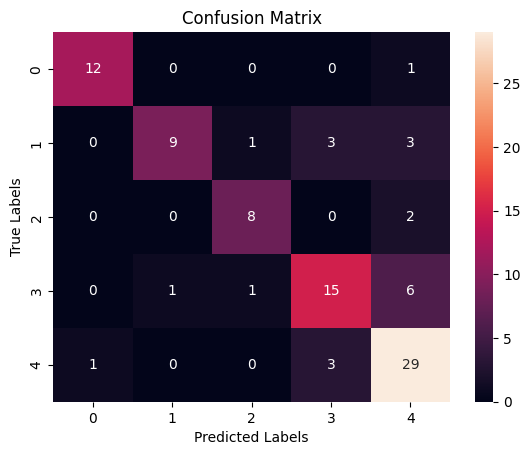

In [37]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()